# Pokemon Go Analysis

Pokemon Go is (was...) a very popular game on mobile platforms where players act as Pokemon Trainers and try to catch various Pokemons around the globe. The aim of this brief analysis is to summarise the statistics of the Pokemons and determine which ones are stronger. Geograpical data is also included in the data set where and it would also be very interesting to verify the claim by the developer (Niantic) that the location of appearance of Pokemon is correlated with their Type.

### Data ETL

2 CSV files will be used and they are obtained from Kaggle.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

df_go = pd.read_csv('pokemonGO.csv')
df_spawn = pd.read_csv('pokemon-spawns.csv')

In [2]:
df_go.head(2)

,Pokemon No.,Name,Type 1,Type 2,Max CP,Max HP,Image URL
0,1,Bulbasaur,Grass,Poison,1079,83,http://cdn.bulbagarden.net/upload/thumb/2/21/0...
1,2,Ivysaur,Grass,Poison,1643,107,http://cdn.bulbagarden.net/upload/thumb/7/73/0...


In [3]:
df_spawn.head(2)

,s2_id,s2_token,num,name,lat,lng,encounter_ms,disppear_ms
0,-9185794522947256000,8085808cc6d,13,Weedle,37.793592,-122.408721,1469520187732,1469519919988
1,-9185794529389707000,8085808b51d,16,Pidgey,37.794746,-122.406420,1469520297172,1469519919992


From the above we can see that in df_go we have identification information about the Pokemon (Pokemon No. and Name) and the properties of the Pokemons (Types, CP and HP). For those who are not familiar with the game, CP is related to how hard a Pokemon hits and HP is related to how tough it is. In other words they are the 'attack' and 'defense' properties respectively.

df_spawn contains information of Pokemon appearance across a time period in the San Fransisco Bay area. In the data we have the Pokemon info, which is useful for joining up the data. Then we have the location(latitude and longitude) of each appearance. We have also got the duration of its appearance (encounter and disappear). The s2 information is irrelevant in this analysis hence they would be excluded.

In [4]:
# drop s2 related columns
df_spawn.drop(['s2_id','s2_token'],axis=1,inplace=True)

In [12]:
# Compute appearance duration
df_spawn['duration_s'] = -(df_spawn['disppear_ms'] - df_spawn['encounter_ms'])/1000

In [13]:
df_spawn.describe()

,num,lat,lng,encounter_ms,disppear_ms,duration_s
count,314105.000000,314105.000000,314105.000000,3.141050e+05,3.141050e+05,3.141050e+05
mean,46.544569,37.291383,-95.059814,1.371451e+12,1.469550e+12,-9.809908e+07
std,36.155881,1.918667,73.256881,3.667958e+11,1.999433e+07,3.667959e+08
min,1.000000,32.188748,-122.611804,-1.000000e+00,1.469520e+12,-1.469670e+09
25%,19.000000,37.322103,-122.337013,1.469542e+12,1.469543e+12,1.785060e+02
50%,41.000000,37.615938,-122.106334,1.469549e+12,1.469549e+12,4.199840e+02
75%,60.000000,37.788990,-118.260931,1.469557e+12,1.469557e+12,6.598370e+02
max,148.000000,43.164284,139.840451,1.469671e+12,1.469670e+12,9.000000e+02


From the describe method above it can be seen that there are 314105 records in the spawn data set. However there are some ureasonable data such as the duration having a negative value. Some Longitude values seems to be off as well as it should not cover a range from -122 to +139. Therefore those data will be investigated further.

In [17]:
# There are 20968 rows in total but to save space only the first 5 are displayed
df_spawn[df_spawn['duration_s']<=0].head()

,num,name,lat,lng,encounter_ms,disppear_ms,duration_s
3,16,Pidgey,37.795644,-122.407128,-1,1469519920134,-1.469520e+09
18,19,Rattata,37.301284,-121.998094,-1,1469520277295,-1.469520e+09
27,133,Eevee,37.301852,-121.950999,-1,1469520277338,-1.469520e+09
32,19,Rattata,37.303030,-121.999782,-1,1469520277364,-1.469520e+09
44,46,Paras,37.303843,-121.975615,-1,1469520277481,-1.469520e+09


In [18]:
'''It is obvious that the encounter_ms are all set to -1 which results in a negative duration. It is assumed that  
this is due to the fact of the encounter time not being recorded. Therefore these values will be excluded from the
analysis of Pokeon appearance duration'''

df_spawn_duration = df_spawn[df_spawn['duration_s']>0]

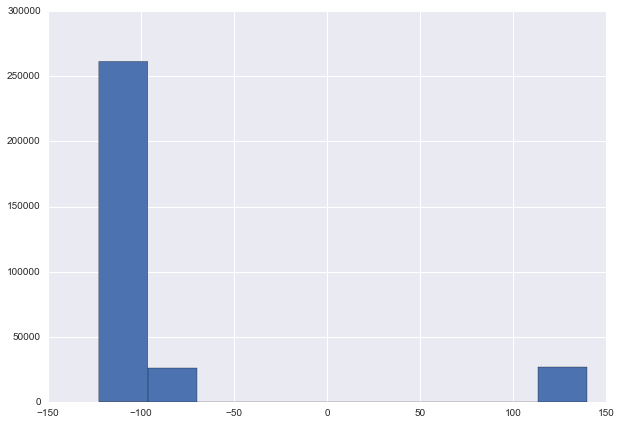

In [19]:
# Plot histogram to show Longitude distribution
df_spawn['lng'].hist(figsize=(10,7))

It is apparent that there are about 25000 cases where the Longitudes are over 100. 

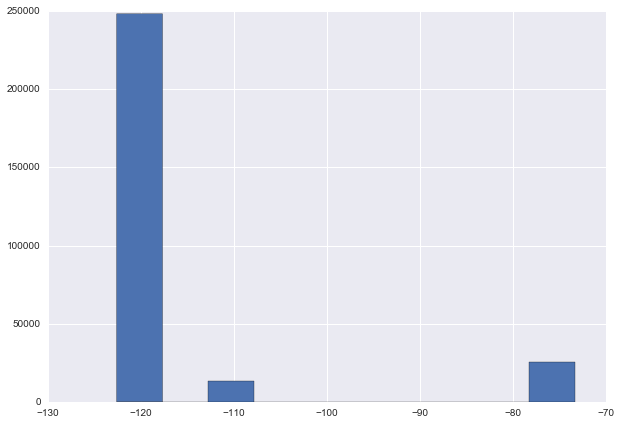

In [24]:
df_spawn[df_spawn['lng']<100]['lng'].hist(figsize=(10,7))

The above plots suggest that the data might not be limited to San Fransisco only as there are multiple location data that are far apart. This can be visualised by plotting the locations in Tableau. We can see from the map below that apart from the SF Bay area, there are other data in for example LA. It turns out that the data set contains data for some ohter locations as well such as New York and even places in Japan! Since it would be better to focus the investigation in one place, it is decided that only the data for SF Bay will be used in geographical analysis. 

<img src='pokemon_location_examle.jpg'>

In [26]:
# Limit data using Latitude and Longitude
df_spawn_geo = df_spawn[(df_spawn['lat']>=37.2) & (df_spawn['lat']<=38) & 
                        (df_spawn['lng']>=121.8) & (df_spawn['lng']<=122.6)]

In [27]:
# Check data type of each features. They seem to be reasonable 
df_spawn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 314105 entries, 0 to 314104
Data columns (total 7 columns):
num             314105 non-null int64
name            314105 non-null object
lat             314105 non-null float64
lng             314105 non-null float64
encounter_ms    314105 non-null int64
disppear_ms     314105 non-null int64
duration_s      314105 non-null float64
dtypes: float64(3), int64(3), object(1)
memory usage: 16.8+ MB


In [28]:
# Look at another data set
df_go.describe()

,Pokemon No.,Max CP,Max HP
count,151.000000,151.000000,151.000000
mean,76.000000,1637.291391,113.350993
std,43.734045,755.261726,45.297417
min,1.000000,264.000000,27.000000
25%,38.500000,1001.500000,83.000000
50%,76.000000,1594.000000,107.000000
75%,113.500000,2170.500000,138.000000
max,151.000000,4174.000000,408.000000


From the above we know that there are 151 unique Pokemon available at the time when the data was collected. Since we have no previous information about CP and HP we can not immediately tell whether they are reasonable. Therefore the data would be visulaised and explored.

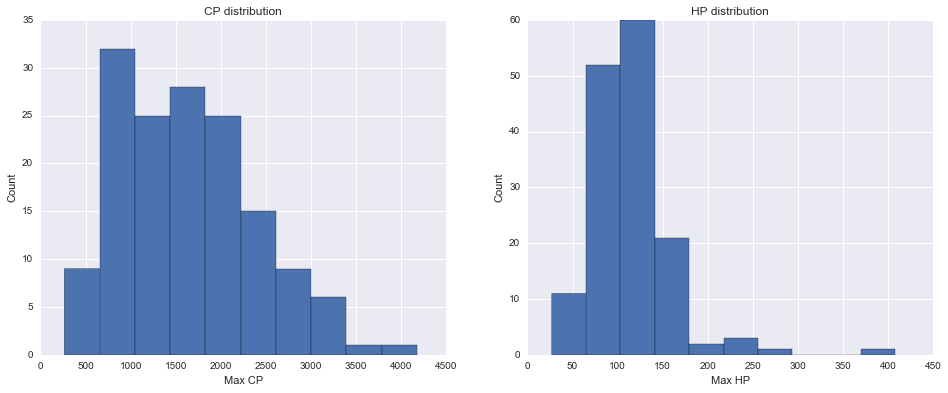

In [32]:
fig = plt.figure(figsize=(16,6))
ax1= fig.add_subplot(121)
ax2= fig.add_subplot(122)
df_go['Max CP'].hist(ax=ax1)
df_go['Max HP'].hist(ax=ax2)
ax1.set(xlabel='Max CP', ylabel='Count', title = 'CP distribution')
ax2.set(xlabel='Max HP', ylabel='Count', title = 'HP distribution')
plt.show()


The diagrams above shows the distribution for both CP and HP are relatively close together without any particular obvious outlier. Although it might be worth to look into the case(s) with a Max HP of over 350.

In [33]:
df_go[df_go['Max HP']>350]

,Pokemon No.,Name,Type 1,Type 2,Max CP,Max HP,Image URL
112,113,Chansey,Normal,NaN,679,408,http://cdn.bulbagarden.net/upload/thumb/c/cd/1...


It turns out the be Chansey. If one has prior knowledge about Pokemon then this should not be a surprise as Chansey has always been a tough Pokemon. It is also a 'nurse' in the anime so we can reasonably comfortable with its high HP (life realted) value. Having understood these features, a final review was carried out.

In [34]:
df_go.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151 entries, 0 to 150
Data columns (total 7 columns):
Pokemon No.    151 non-null int64
Name           151 non-null object
Type 1         151 non-null object
Type 2         67 non-null object
Max CP         151 non-null int64
Max HP         151 non-null int64
Image URL      151 non-null object
dtypes: int64(3), object(4)
memory usage: 8.3+ KB


In [35]:
# There are only 67 non-null values in the Type 2 column. This can be understood as not every Pokemon has more than 1 type
# However this NaN will still need to be filled

df_go['Type 2'] = df_go['Type 2'].fillna('No_Type_2')

### Exploratory Data Analysis (EDA)

Exploratory data analysis is one of the most important part of a data science workflow. This is becuase it allows a data science to understand the structure and relationship that exists within the data. Having such understandings would be very beneficial for hypothesis testings and predictive modelling because some of those operations have certain assumptions. It is through EDA that we can verify those assumptions. It is also important in terms of feature engineering as raw features do not always have the ability to filter out the noise from signals. Combining statistical knowledge, understanding of the data and domain experitse a data scientist would be able to create better features to improve model performance.

The histograms in the above sections can be classified as part of the EDA. However there are more visualisation techniques that are also helpful.

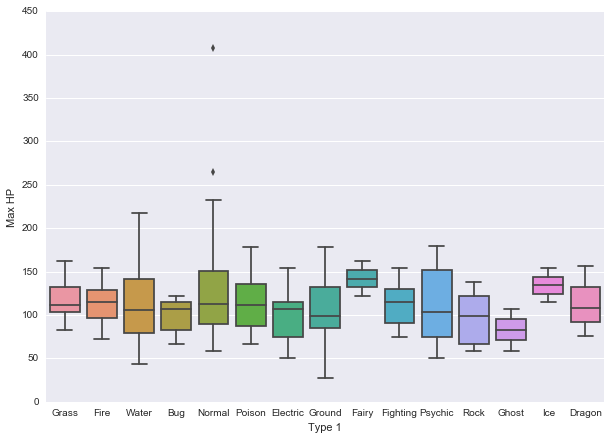

In [38]:
plt.figure( figsize=(10,7))
sns.boxplot(x='Type 1', y='Max HP', data=df_go)
plt.show()